# Machine Learning


**Course: "Introduction to data analysis methods for HEP"**

*Author: Jose A. Hernando*, January 2017

*Particle Physics Deparment. Universidade de Santiago de Compostela, Spain.*

These is a series of lectures on Data Analysis for High Energy Physics. Emphasis is put on Hypothesis testing and Confidence Intervals. They are based on the excellent lectures on statistics by Prosper [1], Cowan [2] and Cranmer[3] given at CERN Academic Training.

Structure of the course:
* General Concepts: probability density functions and likelihoods. Frequentist and bayesian statistics
* Hypothesis testings: test statistic. Continuous hypothesis. CLs method.
* Confidence Interval: Classical and F.C. intervals.
* MVA: Classification and Regression
* Regression: Likelihood estimation.


Structure of the chapter:
* Introduction: MVA
* Fisher Discriminant
* Nearest Neighbors
* Suport Vector Machines
* Decision Trees: Random Forest, Boosted Decision Trees
* Neural Networks


In [1]:
# general imports
%matplotlib inline

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

# possible styles: ggplot (simplicity), bmh (scientify data), 
matplotlib.style.use('ggplot')

# ploting images
from IPython.display import display, Image

In [2]:
from array import array
from sklearn import datasets
from sklearn import metrics

In [3]:
import time

print ' Last Execution ', time.asctime()

 Last Execution  Sun Jan 29 01:14:08 2017


---

## Introduction


In HEP we usually work with events, that correspond normally to collisions or interactions. For each event, we measure a list of quantities, for example, in the LHC, we measure the number of vertices, tracks, the momentum and direction of the particles, the position and energy of neutrals, etc. From these variables, we classify the events and the selected events, measure a relevant quantity. For example, select events where there is a Higgs candidate, and them measure its mass and properties. This is a process in which from a list of variables we end up with only one. We summarize the information. The first steps, is the **classification**, select events that belong to a given cathergory (a Higgs candidate), and then **regression** (measure its mass).

Selection has many applications: identify the particle associated to a track in the experiment (is this a muon? a pion?), identify the flavour of the jet (is a b-jet?). The selection sometimes is based on a series of cuts on the variables. But this is not optimal. What are the techniques to classify a sample of data into different cathegories? How to use them?

In the chapter of Hypothesis testing, we introduced the concept of test-statistics, the scale where to order the measurments according with the possible hypothesis, and identified the likelihood ratio as the best statistics. But sometimes, we do not know the pdfs of our variables. We need to construct a test-statistic, a variable that summarizes the information that is in all the variables into one and can be used as a classification scale. This is done with learning methods.

A **learning method (ML)** predicts the cathegories a **sample** of data. Data is presented as a tuple, or table, there are n-samples of data, and a list of variables, known as **features**. In HEP, a smaple can be an event, and the features: the number of vertices, tracks, etc. And returns a variable, the discriminator, that can be discrete (a value for each cathegory) or continuous (as a test statistics). 

The learning methods are divides in two steps: **learning** and **testing**. In the learning process the methods learns what a data set, a n-samples, in the testing, the method does predictions using a second data set. Methods can be **supervised** or **unsupervised**. 

If the method is supervised, during the learning process, each sample is associated to a true cathegory. This is call the **target**. In HEP we can train a method using MC simulation, (feeding the method with a MC event and idicating if it has a Higgs or not, a b-jet or not) or the data itself (using a sample of known data, for example, this data is from a electron, this is for a foton, etc). The method learns to classify the data. In the testing process will predict the target associated to each sample, according to its learning process. An unsupervised method, has not guidance, it just simple tries to cluster the data. A typical example is the Google net trained with pictures of cats and dogs, without a target in the training, and let them predict, in the testing, if the picture is that of a cat or a dog.

The learning methods can be used for classification or estimation.

We discuss here some popular ML methods in HEP.

The most common used package in HEP is ROOT [] and TMVA []. But in this lectures, we will use the scikit-learn package [] that comes with the Anaconda Python distribution.  


----

labels  ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
nsamples  nfeatures (20000, 10)
nclasses  2


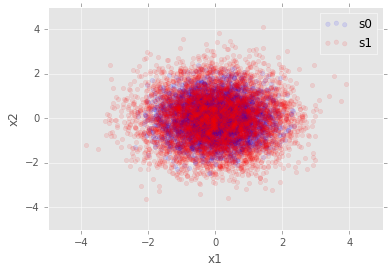

In [4]:
filename = 'chi2'

dpan = pd.read_csv(filename+'.csv')
labels = [str(label) for label in dpan.columns if label.find('x')>=0]

print 'labels ', labels

X = dpan.as_matrix(labels)
y = dpan.target.values
nclasses = np.max(y)+1
print 'nsamples  nfeatures', X.shape
print 'nclasses ', nclasses

nsamples = len(y)
ntrain = nsamples/2
X_train, y_train = X[:ntrain], y[:ntrain]
X_test, y_test = X[ntrain:], y[ntrain:]

fig, ax = plt.subplots()
colors = 4*['blue', 'red', 'yellow', 'black', 'cyan', 'white']
for i in range(nclasses):
    color = colors[i]
    si = (y_train == i)
    ax.scatter(X_train[si, 0], X_train[si, 1], color=color, alpha=0.1,
               label='s{:d}'.format(i))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend();

## 1. Fisher discriminant

Fisher discriminat is a simple algorithm, that compute an hyperplane in the features space that minimizes 

In [5]:
import sklearn.metrics as metrics

def classification_matrix(y_test, y_predict):
    """ compare prediction with test target values
    parameters:
        test: array with the test cathegories
        predict: array with the predicted cathegorites by the classifier
    returns:
        matrix of fraction of the true and flase possitives for each cathegory
    """
    mat = metrics.confusion_matrix(y_test, y_predict)
    n, m = mat.shape
    matp = np.zeros(n*m).reshape(n, m)
    for i in range(n):
        for j in range(m):
            matp[i][j] = float(mat[i][j])/float(np.sum(mat[i,:]))
    print 'classification matrix : \n', mat
    print 'classification matrix fractions :\n', matp
    return mat, matp

def classification_surface2d(X_test, classifier, grid=0.2):
    """ return a grid-mess with the surface classification in a n_leaves=2 problem
    parameters:
        X_test the matrix with n-samples and n-features
        classifier the object classifier
        grid: size of the 2d grid
    returns:
        xx, yy, z: the grid-mess with the classification cathegories 
        on z(x, y) in the (x, y) plane
    """
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    zz = Z.reshape(xx.shape)
    return xx, yy, zz

def proba_surface2d(X_test, classifier, grid=0.2):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    n, m = Z.shape
    zz = np.array([Z[:, i].reshape(xx.shape) for i in range(m)])
    return xx, yy, zz    

In [6]:
def plot_classification_matrix(matp):
    # plot the classification matrix
    fig, ax = plt.subplots()
    ct = ax.imshow(matp, interpolation='nearest', origin='lower')
    fig.colorbar(ct, ax=ax)
    ax.grid(False)
    ax.set_xlabel('target')
    ax.set_ylabel('predict')
    ax.set_title('classification matrix')
    return fig, ax

def plot_classification_surface2d(xx, yy, zz):
    fig, ax = plt.subplots()
    cc = ax.pcolormesh(xx, yy, zz, cmap=plt.cm.jet)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max());
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    fig.colorbar(cc, ax=ax)
    ax.legend()
    ax.set_title('classification surface')
    return fig, ax
        
def plot_proba(proba, y_test, offset=0.0):
    n, m = proba.shape
    fig, axs = plt.subplots(m, 1, figsize=(6, 3*m))    
    colors = 2*['blue', 'red', 'yellow', 'green', 'black', 'cyan']
    n, m = proba.shape
    for i in range(m):
        ax = axs[i]
        for j in range(m):
            sj = (y_test == j)
            ax.hist(offset*j+proba[sj, i], bins=50, color=colors[j], alpha=0.5, 
                    label='x={:d}'.format(j))
        ax.set_xlabel('proba')
        ax.legend()
        ax.set_title('$f(x|H)$ H={:d}'.format(i))
    fig.tight_layout()
    return fig, axs

def plot_proba_surface2d(xx, yy, zz):
    m, m1, m2 = zz.shape
    fig, axs = plt.subplots(m, 1, figsize=(6, 3*m))
    for i in range(m):
        ax = axs[i]
        ct = ax.pcolormesh(xx, yy, zz[i], cmap=plt.cm.jet)
        ax.set_title('proba s{:d}'.format(i))
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max());
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_title('proba - class {:d}'.format(i))
        fig.colorbar(ct, ax=ax)
    fig.tight_layout()
    return fig, axs

def plot_decision(decisions, y_test, title=''):
    fig, ax = plt.subplots()
    nclasses = np.max(y_test)+1
    colors = 4*['blue', 'red', 'yellow', 'black'] 
    for i in range(nclasses):
        color = colors[i]
        si = (y_test == i)
        ax.hist(decisions[si], bins=50, color=color, alpha=0.5, 
                label='class {:d}'.format(i))
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.legend()
    return fig, ax

def plot_roc(decisions, y_test, title=''):
    # They should be only 2 classes
    # decisions should be a continous variable
    fig, ax = plt.subplots()
    size, power, thresholds = metrics.roc_curve(y_test, decisions)
    roc_auc = metrics.auc(size, power)
    ax.plot(size, power, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('significance')
    ax.set_ylabel('power')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    return fig, ax

In [7]:
def ana_classifier(classifier, X_test, y_test):
    
    print classifier
    
    # dimensions
    nsamples, nfeatures = X_test.shape
    nclasses = np.max(y_test)+1
    print ' test samples {:d}'.format(nsamples)
    print ' classes {:d}, features {:d}'.format(nclasses, nfeatures)
    
    # score
    y_predict = classifier.predict(X_test)
    print 'score ', classifier.score(X_test, y_test)
    mat, matp = classification_matrix(y_test, y_predict)
    fig, ax = plot_classification_matrix(matp)
    
    # classification success
    if (nfeatures == 2):
        xx, yy, zz = classification_surface2d(X_test, classifier)
        fig, ax = plot_classification_surface2d(xx, yy, zz)
    
    # probability 
    proba = classifier.predict_proba(X_test)
    fig, ax = plot_proba(proba, y_predict)
    
    if (nfeatures == 2):
        xx, yy, zz = proba_surface2d(X_test, lr)
        fig, ax = plot_proba_surface2d(xx, yy, zz)
    
    if (nclasses == 2):
        decisions = np.array([proba[i,1]/np.sum(proba[i,:]) for i in range(nsamples)])
        fig, ax = plot_decision(decisions, y_test, title='proba ratio')
        fig, ax = plot_roc(decisions, y_test, title='proba roc')

    # ROC curve
    if ((nclasses == 2) and hasattr(classifier, 'decision_function')):
            print 'classifier has decision function'
            decisions = classifier.decision_function(X_test)
            fig, ax = plot_decision(decisions, y_test, 'decision ')
            fig, ax = plot_roc(decisions, y_test, 'ROC decision')

    return 

training...
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
 test samples 10000
 classes 2, features 10
score  0.4898
classification matrix : 
[[ 195 4495]
 [ 607 4703]]
classification matrix fractions :
[[ 0.04157783  0.95842217]
 [ 0.11431262  0.88568738]]
classifier has decision function


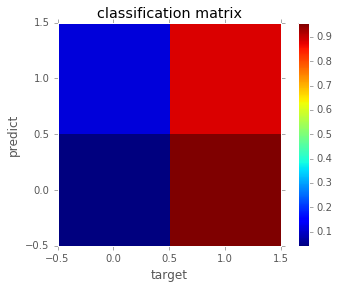

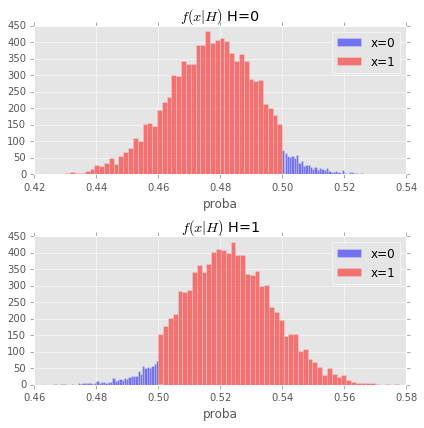

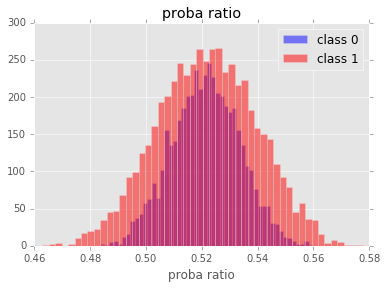

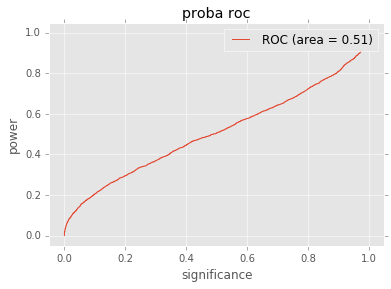

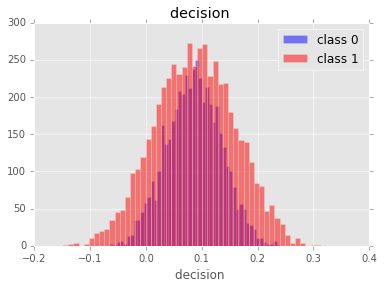

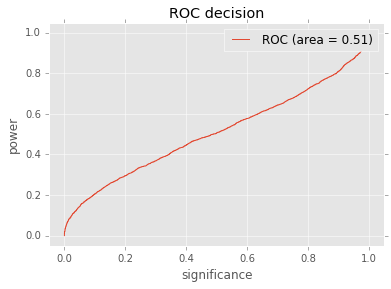

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
print 'training...'
lr.fit(X_train, y_train)

cc = ana_classifier(lr, X_test, y_test)

## 2 K Nearest Neighbors


A *K Nearest Neighbors* (kNN) is a classifier that predict the catherogy of a sample, by comparing its 'distance' to the neighbors of the testing samples. The are a different methods, depending if they search for $k$ nearest neighbors of inside a radious. The metric here is important, usually, it is euclidean. They are not 'learning' methods and more 'memory' methods, as they 'memorize' the position of the training samples.


KNN parameters : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_estimator_type', '_fit', '_fit_X', '_fit_method', '_get_param_names', '_init_params', '_pairwise', '_tree', 'algorithm', 'fit', 'get_params', 'kneighbors', 'kneighbors_graph', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'predict', 'predict_proba', 'radius', 'score', 'set_params', 'weights']
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
    

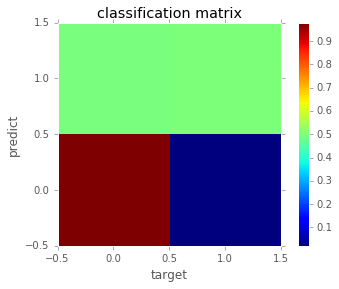

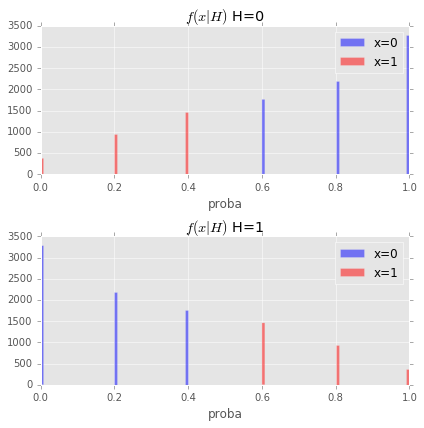

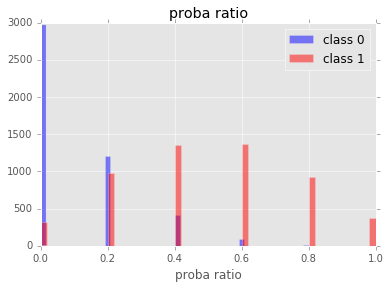

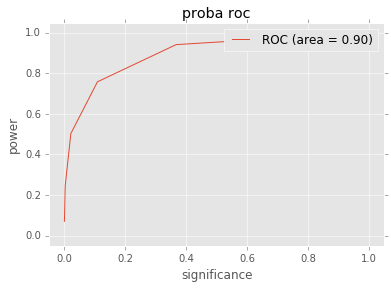

In [9]:
# import the neighbors ml method
import sklearn.neighbors as neighbors

# create the classifier
knn = neighbors.KNeighborsClassifier()
print 'KNN parameters :', knn
print dir(knn)

# train the classifier
knn.fit(X_train, y_train)

cc = ana_classifier(knn, X_test, y_test)

## Support Vector Machines


training... 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
 test samples 10000
 classes 2, features 10
score  0.531
classification matrix : 
[[   0 4690]
 [   0 5310]]
classification matrix fractions :
[[ 0.  1.]
 [ 0.  1.]]
classifier has decision function


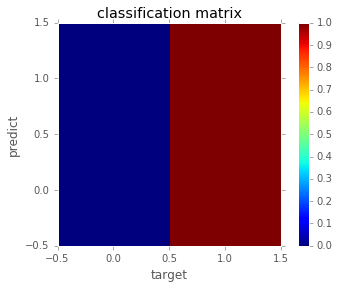

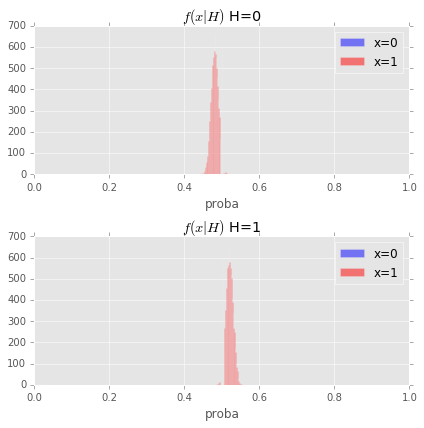

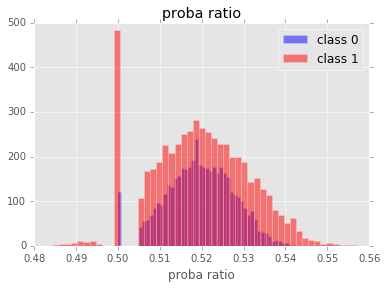

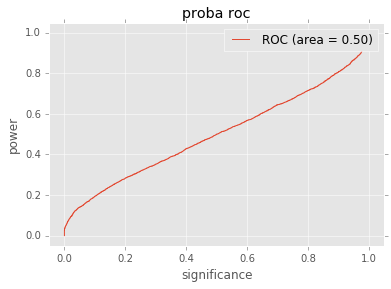

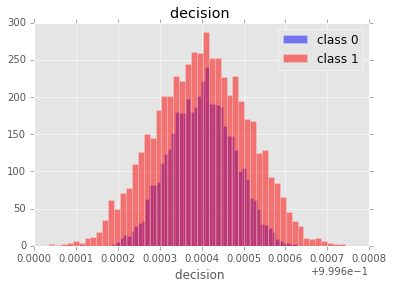

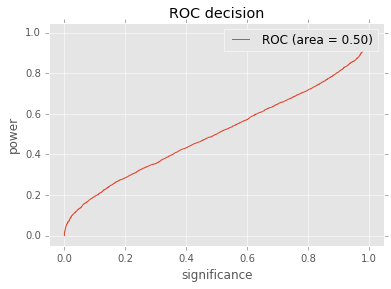

In [10]:
from sklearn import svm

# svc = svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr') 
svc = svm.SVC(kernel='linear', probability=True) 

print 'training... '
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)

cc = ana_classifier(svc, X_test, y_test)


## 3. Decision Trees

A Decision Tree is a classifier based on a tree is cuts. The samples are classified in different branches of the tree. To be in a branch the sample has to pass the list of cuts of that branch. The idea is that in a branch should be samples of one cathegory, or little contaminated with samples of other cathegories.  

### Decision Tree

training...
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
 test samples 10000
 classes 2, features 10
score  0.7794
classification matrix : 
[[3645 1045]
 [1161 4149]]
classification matrix fractions :
[[ 0.7771855   0.2228145 ]
 [ 0.21864407  0.78135593]]


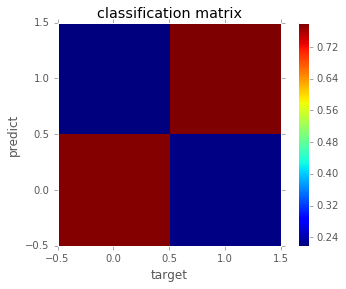

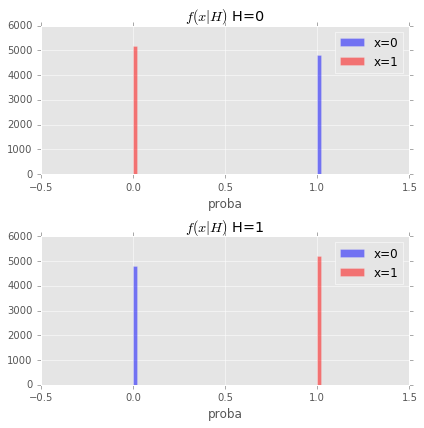

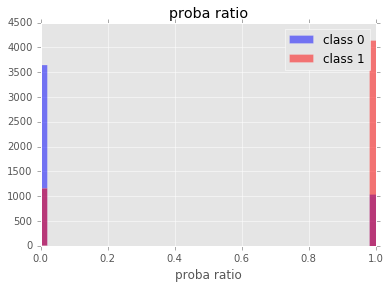

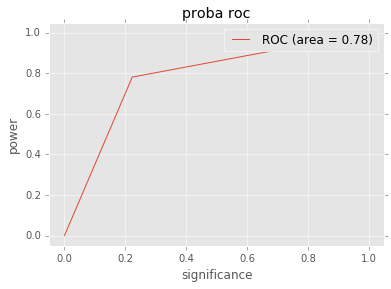

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

print 'training...'
tree.fit(X_train, y_train)

cc = ana_classifier(tree, X_test, y_test)

### Random Forest

Random Forest is a classifier that averages the output of several decision trees. It uses bootstrap techniques to generates the tranining samples for the trees.

training...
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
 test samples 10000
 classes 2, features 10
score  0.8597
classification matrix : 
[[4021  669]
 [ 734 4576]]
classification matrix fractions :
[[ 0.85735608  0.14264392]
 [ 0.13822976  0.86177024]]


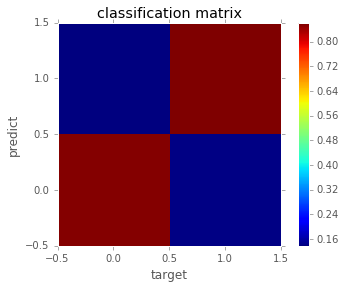

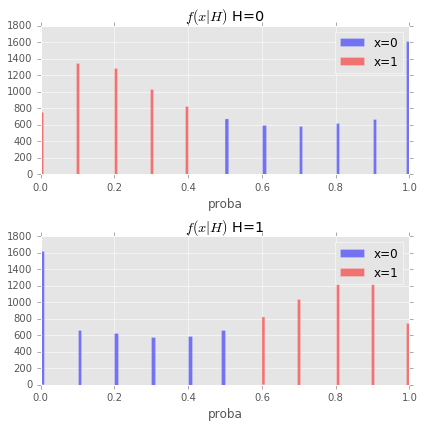

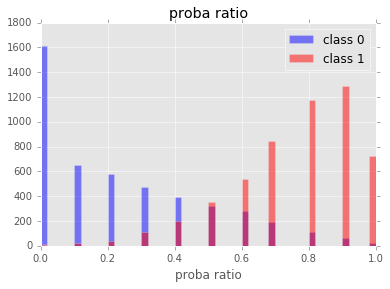

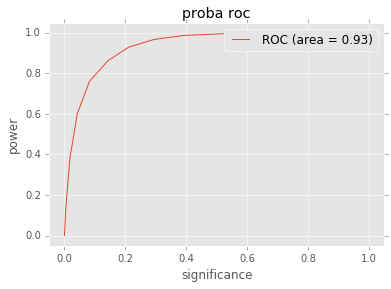

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

print 'training...'
rfc.fit(X_train, y_train)

cc = ana_classifier(rfc, X_test, y_test)

### Boosted Decision Tree

training...
AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=500.0,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)
 test samples 10000
 classes 2, features 10
score  0.9036
classification matrix : 
[[4198  492]
 [ 472 4838]]
classification matrix fractions :
[[ 0.89509595  0.10490405]
 [ 0.08888889  0.91111111]]
classifier has decision function


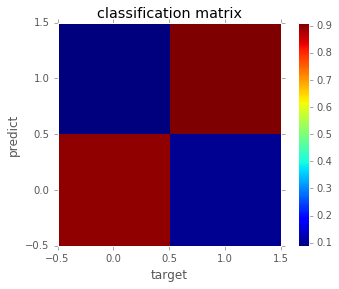

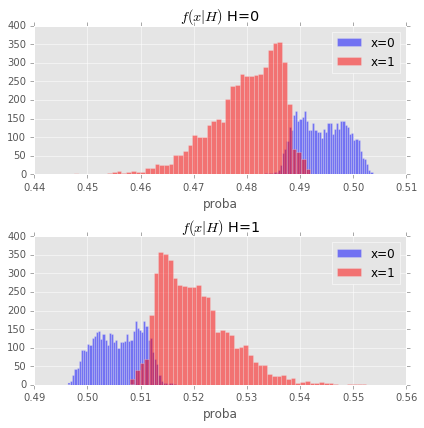

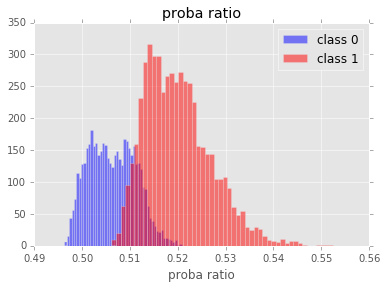

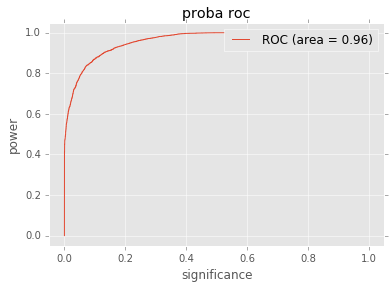

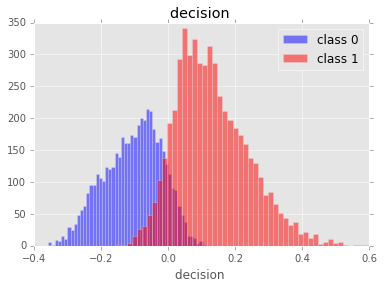

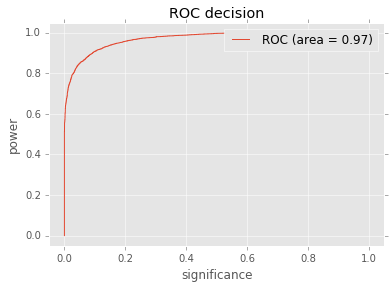

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=0.05*len(X_train))
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

print 'training...'
bdt.fit(X_train, y_train)

cc = ana_classifier(bdt, X_test, y_test)

## Neural Networks

In [14]:
import sklearn.neural_network as neural_network
print dir(neural_network)
#mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
#                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
#                    learning_rate_init=.1)
# print 'training...'
# nn.fit(X_train, y_train)
# cc = ana_classifier(nn, X_test, y_test)


['BernoulliRBM', '__all__', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__', 'rbm']


## Comparison of Classifiers

Comparison of different classifiers

training  LogRegr
training  kNN
training  SVC
training  tree
training  RanForest
training  BDT
LogRegr  score 0.490
kNN  score 0.726
SVC  score 0.531
tree  score 0.781
RanForest  score 0.862
BDT  score 0.879


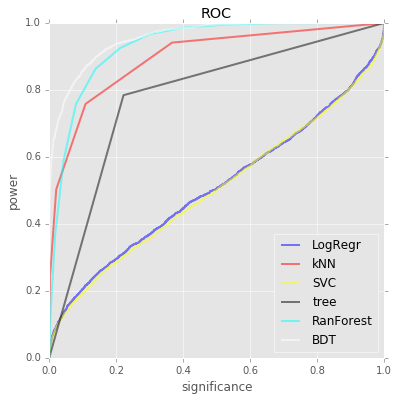

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
# from sklearn.neural_networks import MLPClassifier (Not there!!)

names = ["LogRegr", "kNN", "SVC",
         "tree", "RanForest", "BDT"]
nclassifiers = len(names)

nclasses = np.max(y_test)+1
if (nclasses != 2):
    print "ROC only possible for 2 classes!"
    assert()

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel='linear', probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier()]

for i in range(nclassifiers):
    print 'training ', names[i]
    classifiers[i].fit(X_train, y_train)
    
def decision_proba(proba):
    nsamples, nclasses = proba.shape
    decisions = np.array([proba[i,1]/np.sum(proba[i,:]) for i in range(nsamples)])
    return decisions
    
scores = np.array([classifier.score(X_test, y_test) for classifier in classifiers])
probas = [classifier.predict_proba(X_test) for classifier in classifiers]
decisions = np.array([decision_proba(proba) for proba in probas])
for i, classifier in enumerate(classifiers):
    if (hasattr(classifier, 'decision_function')):
        decisions[i] = classifier.decision_function(X_test)

for i in range(len(names)):
    print names[i], ' score {:5.3f}'.format(scores[i])

fig, ax = plt.subplots(figsize=(6, 6))

colors = 4*['blue', 'red', 'yellow', 'black', 'cyan', 'white']
for i in range(nclassifiers):
    color = colors[i]
    decision = decisions[i]
    name = names[i]
    size, power, thresholds = metrics.roc_curve(y_test, decision)
    ax.plot(size, power, color=color, lw=2, alpha=0.5, label=name)
ax.set_xlabel('significance')
ax.set_ylabel('power')
ax.set_title('ROC')
ax.legend(loc=4);